In [155]:
import torchmetrics
import sys
import numpy as np
sys.path.append('C:/Users/kupec/OneDrive/Desktop/neuroforest-main/neuroforest-master')
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from neuroforest.dataset import image_loader
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




with_mushroom_no_timestamp


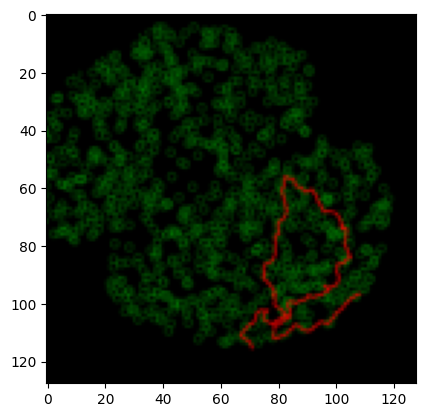

(128, 128, 3)

In [164]:
image, label = image_loader[87]
print(image_loader.get_category(3))
image = image.permute(1, 2, 0).numpy() 
plt.imshow(image)
plt.show()
image.shape


In [188]:
def filter(image_loader, category):
    indices = []
    for i in range(len(image_loader)):
        if image_loader.get_category(i) == category:
            indices.append(i)
    return Subset(image_loader, indices)

def get_data_augmentation_transforms():
    return transforms.Compose([
        transforms.RandomRotation(degrees=(-30, 30)),  # Rotation aléatoire
        transforms.RandomHorizontalFlip(),              # Flip horizontal
        transforms.Resize((128, 128)),                  # Redimensionner les images
        transforms.ToTensor(),                          # Conversion en tenseur
    ])


def create_train_test_split(image_set, test_size = 0.2):
    dataset_size = len(image_set)
    test_size = int(test_size * dataset_size)
    train_size = dataset_size - test_size
    
    return random_split(image_set, [train_size, test_size])

def augment_dataset(dataset, augmentation_factor, transforms):
    augmented_datasets = [dataset]  # Inclure le dataset original
    for _ in range(augmentation_factor - 1):
        augmented_dataset = Subset(dataset, range(len(dataset)))  # Copie des données
        augmented_dataset.dataset.transform = transforms  # Ajouter des transformations
        augmented_datasets.append(augmented_dataset)
    
    # Concaténer toutes les copies augmentées
    return ConcatDataset(augmented_datasets)


def create_dataloader(dataset, batch_size=32, transforms=None, shuffle=True):
    if transforms:
        dataset = Subset(dataset, range(len(dataset)))  # Créer un sous-ensemble
        dataset.dataset.transform = transforms
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)



filtered_set = filter(image_loader, 'with_mushroom_with_timestamp')
train, test = create_train_test_split(filtered_set, 0.2)

aug_train = augment_dataset(train, 5, get_data_augmentation_transforms())
aug_test = augment_dataset(test, 5, get_data_augmentation_transforms())

train_loader = create_dataloader(aug_train, transforms=get_data_augmentation_transforms())
test_loader = create_dataloader(aug_test, transforms=get_data_augmentation_transforms())



In [ ]:
for batch, label in train_loader:
    print(batch.shape)
    print(label)
    break

torch.Size([3, 128, 128])
{'sujet': ['5', '14', '32', '15', '7', '16', '28', '19', '6', '19', '32', '9', '39', '24', '12', '10', '21', '23', '36', '26', '26', '13', '4', '38', '12', '13', '27', '8', '11', '21', '36', '12'], 'Name': ['celia', 'Dylan', 'Ilian', 'Alice', 'Antoine', 'Thomas', 'Tristan', 'Angela', 'sabine', 'Angela', 'Ilian', 'gouwy', 'Alban', 'Thelma', 'maxime', 'nellia', 'mike', 'Jeanne', 'Clara', 'Giorgia', 'Giorgia', 'Alexis', 'Richard', 'Eugenie', 'maxime', 'Alexis', 'ana', 'Ines', 'abdelmoumen', 'mike', 'Clara', 'maxime'], 'Q1.1': ['c', 'b', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'a', 'b', 'b', 'b'], 'Q1.2.1': ['1', '4', '5', '2', '4', '2', '4', '2', '5', '2', '5', '5', '5', '5', '4', '4', '3', '4', '4', '4', '4', '3', '3', '5', '4', '3', '3', '4', '2', '3', '4', '4'], 'Q1.2.2': ['3', '4', '5', '3', '4', '2', '3', '3', '4', '3', '5', '5', '5', '5', '4', '2', '4', '4', '5', '4', 

In [189]:
def calculate_score(labels):
    score_keys = ['asrs1', 'asrs2', 'asrs3', 'asrs4', 'asrs5', 'asrs6', 'asrs7', 'asrs8', 'asrs9', 'asrs10', 'asrs11', 'asrs12', 'asrs13', 'asrs14', 'asrs15', 'asrs16', 'asrs17', 'asrs18']
    score_final = []
    for i in range(int(len(labels["Name"]))):
        score = sum(int(labels[key][i]) for key in score_keys)
        score_final.append(score)
    return score_final

for batch in test_loader:
    images, labels = batch
    print(labels)
    print(len(calculate_score(labels)))
    break


{'sujet': ['26', '29', '22', '22', '22', '31', '22', '22', '26', '15', '15', '29', '15', '9', '1', '26', '22', '16', '31', '15', '2', '22', '9', '5', '2', '27', '17', '22', '29', '9', '31', '4'], 'Name': ['Giorgia', 'Kurshidh', 'Tiffany', 'Tiffany', 'Tiffany', 'Emmanuel', 'Tiffany', 'Tiffany', 'Giorgia', 'Alice', 'Alice', 'Kurshidh', 'Alice', 'gouwy', 'Eloise', 'Giorgia', 'Tiffany', 'Thomas', 'Emmanuel', 'Alice', 'Omer', 'Tiffany', 'gouwy', 'celia', 'Omer', 'ana', 'Asma', 'Tiffany', 'Kurshidh', 'gouwy', 'Emmanuel', 'Richard'], 'Q1.1': ['b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'a', 'b', 'a', 'b', 'b', 'a', 'b', 'a', 'b', 'b', 'a', 'a', 'c', 'b', 'a', 'b', 'a', 'a', 'a', 'a', 'b'], 'Q1.2.1': ['4', '3', '5', '5', '5', '5', '5', '5', '4', '2', '2', '3', '2', '5', '2', '4', '5', '2', '5', '2', '2', '5', '5', '1', '2', '3', '5', '5', '3', '5', '5', '3'], 'Q1.2.2': ['4', '4', '5', '5', '5', '5', '5', '5', '4', '3', '3', '4', '3', '5', '3', '4', '5', '2', '5', '3', '3', '5', '5',

17


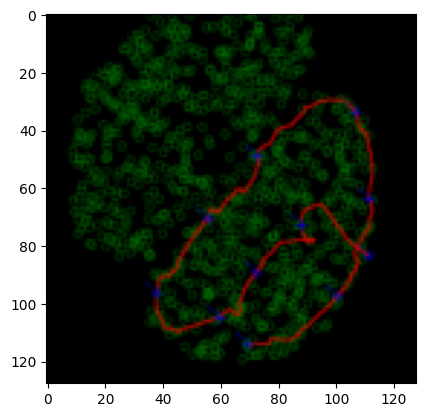

In [202]:
for batch, label in train_loader:
    plt.imshow(batch[0].permute(1, 2, 0))
    print(calculate_score(label)[0])
    break

In [203]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(24 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 1)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 24 * 32 * 32)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = 53*F.sigmoid(x)
        return x

In [219]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

for batch, label in train_loader:
    label = torch.tensor(calculate_score(label)).float()
    batch, label = batch.to(device), label.to(device)
    output = model(batch)
    print(output.flatten())
    print(label)
    print(F.mse_loss(output, label))
    break
for batch, label in test_loader:
    label = torch.tensor(calculate_score(label)).float()
    batch, label = batch.to(device), label.to(device)
    output = model(batch)
    print(output.flatten())
    print(label)
    print(F.mse_loss(output, label))
    break

print(len(train_loader.dataset))


tensor([23.8378, 23.8260, 23.8245, 23.8373, 23.8373, 23.8411, 23.8489, 23.8390,
        23.8267, 23.8484, 23.8444, 23.8433, 23.8472, 23.8413, 23.8380, 23.8299,
        23.8220, 23.8348, 23.8308, 23.8397, 23.8334, 23.8229, 23.8210, 23.8368,
        23.8357, 23.8511, 23.8346, 23.8143, 23.8503, 23.8601, 23.8436, 23.8435],
       grad_fn=<ViewBackward0>)
tensor([49., 48., 32., 45., 29., 53., 33., 49., 26., 53., 35., 21., 34., 33.,
        34., 53., 34., 32., 53.,  4., 48., 39., 53., 24., 33., 19., 24., 31.,
        34., 21., 36., 26.])
tensor(279.8575, grad_fn=<MseLossBackward0>)


C:\Users\kupec\AppData\Local\Temp\ipykernel_14904\3891846844.py:10: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(output, label))


tensor([23.8306, 23.8314, 23.8202, 23.8508, 23.8383, 23.8434, 23.8320, 23.8422,
        23.8452, 23.8350, 23.8282, 23.8268, 23.8169, 23.8401, 23.8534, 23.8387,
        23.8334, 23.8310, 23.8333, 23.8346, 23.8406, 23.8387, 23.8453, 23.8327,
        23.8372, 23.8534, 23.8520, 23.8479, 23.8290, 23.8237, 23.8369, 23.8283],
       grad_fn=<ViewBackward0>)
tensor([32., 32., 32., 23., 32., 22., 34., 32., 26., 24., 34., 36., 32., 20.,
        34., 20., 32., 36., 20., 34., 39., 40., 24., 26., 32., 32., 34., 26.,
        22., 36., 24., 32.])
tensor(68.2388, grad_fn=<MseLossBackward0>)
305


C:\Users\kupec\AppData\Local\Temp\ipykernel_14904\3891846844.py:18: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(output, label))


Epoch 1, training loss: 3.5671968053598873
Epoch 1, testing loss: 2.4729173787434897
Epoch 2, training loss: 3.4421438248431095
Epoch 2, testing loss: 2.7309661356608075
Epoch 3, training loss: 3.4879318737592855
Epoch 3, testing loss: 2.2714965311686197
Epoch 4, training loss: 3.2745070785772605
Epoch 4, testing loss: 2.5890929158528646
Epoch 5, training loss: 3.562593253714139
Epoch 5, testing loss: 2.8401303100585937
Epoch 6, training loss: 3.2558021420338115
Epoch 6, testing loss: 3.1159251912434898
Epoch 7, training loss: 3.189693063204406
Epoch 7, testing loss: 2.444583028157552
Epoch 8, training loss: 2.9749721089347463
Epoch 8, testing loss: 2.801868693033854
Epoch 9, training loss: 2.9668036664118533
Epoch 9, testing loss: 2.635481363932292
Epoch 10, training loss: 2.889565076984343
Epoch 10, testing loss: 2.5771246337890625
Epoch 11, training loss: 2.7599541085665344
Epoch 11, testing loss: 2.6839204915364583
Epoch 12, training loss: 2.6569012751344774
Epoch 12, testing loss:

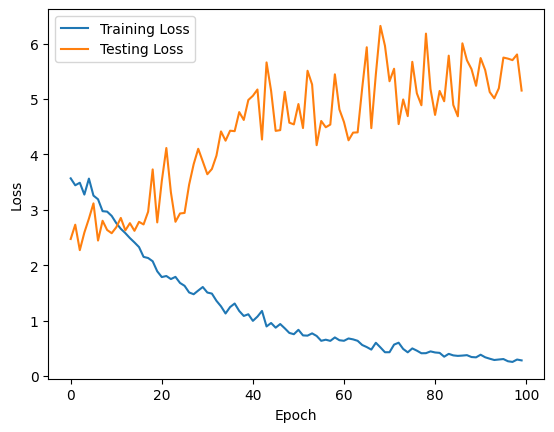

In [221]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
training_loss = []
testing_loss = []
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0
    for images, labels in train_loader:
        labels = torch.tensor(calculate_score(labels)).float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    training_loss.append(train_running_loss/len(train_loader.dataset))
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            labels = torch.tensor(calculate_score(labels)).float()
            images = images.to(device)
            outputs = model(images).flatten()
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
    testing_loss.append(test_running_loss/len(test_loader.dataset))

    
    print(f"Epoch {epoch+1}, training loss: {train_running_loss/len(train_loader.dataset)}")
    print(f"Epoch {epoch+1}, testing loss: {test_running_loss/len(test_loader.dataset)}")
    
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
